
# Energy Demand Forecasting with Granite Timeseries - Preprocessor Use and Performance Evaluation

TinyTimeMixers (TTMs) are compact pre-trained models for Multivariate Time-Series Forecasting, open-sourced by IBM Research. With less than 1 Million parameters, TTM introduces the notion of the first-ever "tiny" pre-trained models for Time-Series Forecasting. TTM outperforms several popular benchmarks demanding billions of parameters in zero-shot and few-shot forecasting and can easily be fine-tuned for multi-variate forecasts.

In this recipe, we move beyond simple prediction to training a Preprocessor and evaluating the model. We evaluate the performance of our model on a real-world dataset containing energy demand data from Spain.

## Setting Up

### Install the TSFM Library 

The [granite-tsfm library](https://github.com/ibm-granite/granite-tsfm) provides utilities for working with Time Series Foundation Models (TSFM). Here the pinned version is retrieved and installed.

In [ ]:
# Install the tsfm library
! pip install "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.17" -U

### Import Packages

From `tsfm_public`, we use the TinyTimeMixer model, preprocessor, forecasting pipeline, and plotting function.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tsfm_public import (
    TimeSeriesForecastingPipeline,
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
)
from tsfm_public.toolkit.time_series_preprocessor import prepare_data_splits
from tsfm_public.toolkit.visualization import plot_predictions

### Specify configuration variables

We provide the names of the timestamp column and the target column to be predicted. The context length and predition length (in time steps) is set to match the pretrained model.

In [ ]:
timestamp_column = "time"
target_columns = ["total load actual"]

context_length = 512  # the max context length for the 512-96 model
prediction_length = 96  # the max forecast length for the 512-96 model

## Preparing the Data

### Download the data

We'll work with a dataset of hourly electrical demand, generation by type, and weather in Spain. This dataset was originally available [from Kaggle here.](https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather) To simplify access to the data, we will make use of versions available as Hugging Face datasets ([energy consumption](https://huggingface.co/datasets/vitaliy-sharandin/energy-consumption-hourly-spain) and [weather](https://huggingface.co/datasets/vitaliy-sharandin/energy-consumption-weather-hourly-spain)).

In [ ]:
DATA_FILE_PATH = "hf://datasets/vitaliy-sharandin/energy-consumption-hourly-spain/energy_dataset.csv"

### Read in the data

We parse the CSV into a pandas dataframe. In subsequent steps we will split the input dataframe.

In [ ]:
# Read in the data from the downloaded file.
input_df = pd.read_csv(DATA_FILE_PATH, parse_dates=[timestamp_column])

# Show the last few rows of the dataset.
input_df.tail()

### Plot a segment of the target series

Here we inspect a preview of the target time series.

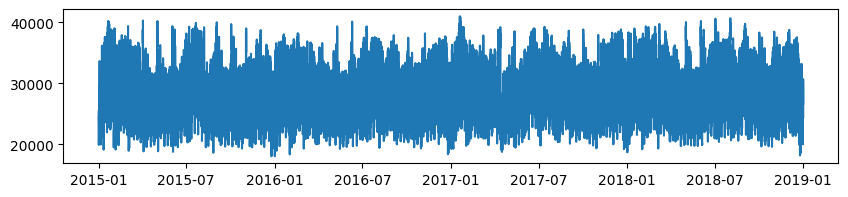

In [ ]:
fig, axs = plt.subplots(len(target_columns), 1, figsize=(10, 2 * len(target_columns)), squeeze=False)
for ax, target_column in zip(axs, target_columns):
    ax[0].plot(input_df[timestamp_column], input_df[target_column])

## Preprocessing the Data

### Split the data into training, validation, and testing sets

We split the data into training, validation, and test sets. The training set is used to train the preprocessor, while the test set is used to evaluate the model performance.

In [ ]:
split_config = {"train": 0.7, "test": 0.2}

train_df, valid_df, test_df = prepare_data_splits(input_df, context_length=context_length, split_config=split_config)
print(f"Data lengths: train = {len(train_df)}, val = {len(valid_df)}, test = {len(test_df)}")

### Train the Preprocessor

The preprocessor is trained on the training portion of the input data to learn the scaling factors. The scaling will be applied when we use the preprocess method of the time series preprocessor.

In [ ]:
column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": [],
    "target_columns": target_columns,
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=prediction_length,
    scaling=True,
    scaler_type="standard",
)

trained_tsp = tsp.train(train_df)

## Evaluating the Model

### Set up zero shot model
The pretrained TTM model is hosted on [HuggingFace](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1), and is loaded into a `TinyTimeMixerForPrediction` model. We have one input channel in this example.

In [ ]:
# Instantiate the model.
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-r2",  # Name of the model on HuggingFace.
    num_input_channels=len(target_columns),  # Number of input columns.
)

### Run the model

Run the model using a forecasting pipeline, on preprocessed test data.

In [ ]:
# Create a pipeline.
pipeline = TimeSeriesForecastingPipeline(
    zeroshot_model,
    device="cpu",  # Specify your local GPU or CPU.
    feature_extractor=tsp,
)

# Make a forecast on the target column given the input data.
zeroshot_forecast = pipeline(test_df)
zeroshot_forecast.head()

### Evaluate the Model

Evaluate the model on the test dataset using a custom metric. In this case we define three standard metrics, mean squared error (MSE), root mean squared error (RMSE), and mean absolute error (MAE).

In [ ]:
def custom_metric(actual, prediction, column_header="results"):
    """Simple function to compute MSE"""
    a = np.asarray(actual.tolist())
    p = np.asarray(prediction.tolist())

    mask = ~np.any(np.isnan(a), axis=1)

    mse = np.mean(np.square(a[mask, :] - p[mask, :]))
    mae = np.mean(np.abs(a[mask, :] - p[mask, :]))
    return pd.DataFrame(
        {
            column_header: {
                "mean_squared_error": mse,
                "root_mean_squared_error": np.sqrt(mse),
                "mean_absolute_error": mae,
            }
        }
    )


custom_metric(
    zeroshot_forecast["total load actual"], zeroshot_forecast["total load actual_prediction"], "zero-shot forecast"
)

,zero-shot forecast
mean_squared_error,8.635129e+06
root_mean_squared_error,2.938559e+03
mean_absolute_error,2.252154e+03


### Plot the Predictions vs. Actuals

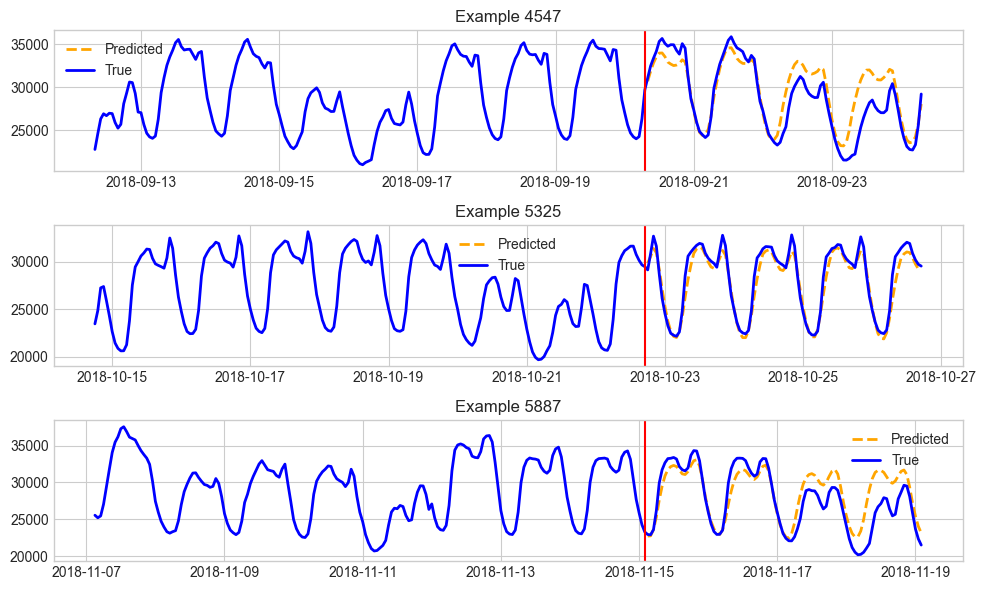

In [ ]:
# plot
plot_predictions(
    input_df=test_df,
    predictions_df=zeroshot_forecast,
    freq="h",
    timestamp_column=timestamp_column,
    channel=target_column,
    indices=[4547, 5325, 5887],
)

## Making the Forecast

### Use the pipeline to make a forecast

Use the forecasting pipeline we assembled above to make a forward prediction from the end of the original dataset.

In [ ]:
historical = input_df.iloc[-context_length:].copy()

# Make a forecast on the target column given the input data.
zeroshot_forecast = pipeline(historical)
zeroshot_forecast.head()

,time,total load actual_prediction,total load actual
0,2018-12-31 23:00:00+01:00,"[23465.362321421962, 22127.95776837158, 21162....","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


### Plot predictions along with the historical data.

The predicted series picks up where the historical data ends, and we can see that it predicts a continuation of the cyclical pattern and an upward trend.

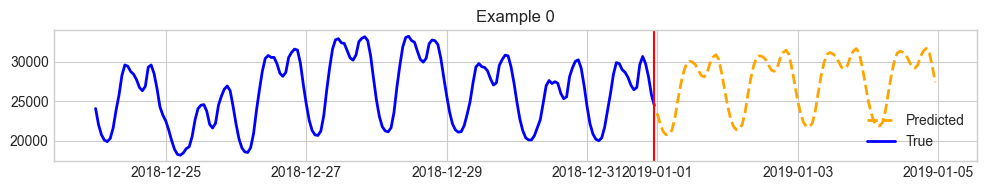

In [ ]:
# Pre-cast the timestamp to avoid dtype inference warnings
historical[timestamp_column] = pd.to_datetime(historical[timestamp_column])

# Plot the historical data and predicted series
plot_predictions(
    input_df=historical,
    predictions_df=zeroshot_forecast,
    freq="h",
    timestamp_column=timestamp_column,
    channel=target_column,
    indices=[0],
)

## Links
* Library: [Granite TSFM on Github](https://github.com/ibm-granite/granite-tsfm)
* Model: [TinyTimeMixer on HuggingFace](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1)
* Dataset: [Hourly Energy Demand Generation and Weather on Kaggle](https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather)